# This notebook is an example of:
### - How to use the yfinance to get stock market data;
### - How to perform a 1-day forecast with ARIMA on Dolar exchange rate from Ibovespa;
### - How to perform a 1-day forecast with ARIMA on Petrobras(Petr4) stocks from Ibovespa;

In [3]:
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pandas_datareader as web
import seaborn as sns
from math import sqrt
from sklearn.metrics import mean_squared_error
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.arima.model import ARIMA

In [4]:
#load data from Brazilian stock exchange market IBOVESPA
tickers = ["^BVSP", "USDBRL=x"]
ibovDolar = web.get_data_yahoo(tickers)["Close"]
ibovDolar = ibovDolar.rename(columns = {'^BVSP': 'IBOV','USDBRL=x': 'DOLAR'}, inplace = False)
ibovDolar.head()

Symbols,IBOV,DOLAR
Date,,
2016-11-11,59184.0,3.3956
2016-11-14,59657.0,3.3900
2016-11-15,NaN,3.4403
2016-11-16,60759.0,3.4417
2016-11-17,59770.0,3.4507


In [5]:
#check missing data in dolar exchange rate and ibovespa index columns
cotCol = ibovDolar['DOLAR'].shape
ibovCol = ibovDolar['IBOV'].shape

print("Missing percentage of DOLAR data {:.2f}%.".format(100*(ibovDolar['DOLAR'].isnull().sum()/cotCol[0])))      
print("Missing percentage of IBOV data {:.2f}%.".format(100*(ibovDolar['IBOV'].isnull().sum()/ibovCol[0])))

Missing percentage of DOLAR data 10.09%.
Missing percentage of IBOV data 14.93%.


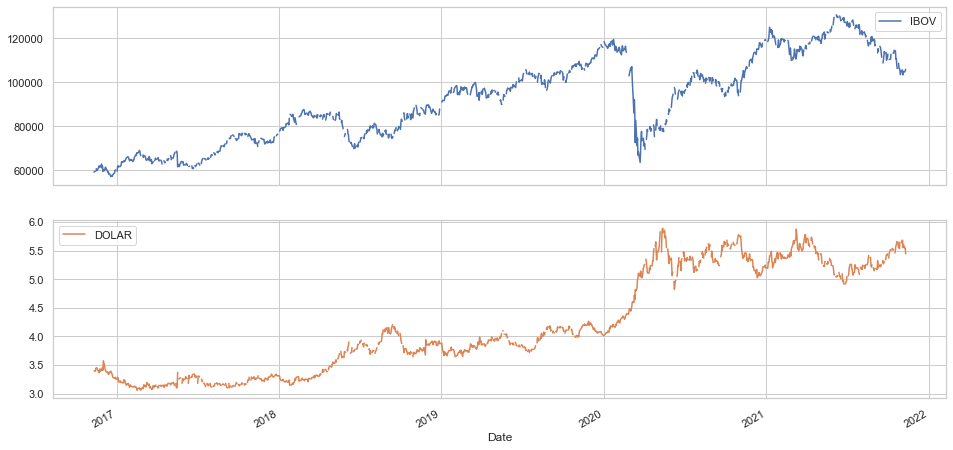

In [6]:
#visualization of missing data
sns.set_theme(style="whitegrid")
ibovDolar.plot(subplots=True, figsize=(16, 8))
plt.show()

In [7]:
#inpute missing data with interpolation.
ibovDolar['DOLAR'] = np.where(ibovDolar['DOLAR'] == 0, np.nan, ibovDolar['DOLAR'])
ibovDolar['DOLAR'] = ibovDolar.DOLAR.interpolate()

ibovDolar['IBOV'] = np.where(ibovDolar['IBOV'] == 0, np.nan, ibovDolar['IBOV'])
ibovDolar['IBOV'] = ibovDolar.IBOV.interpolate()

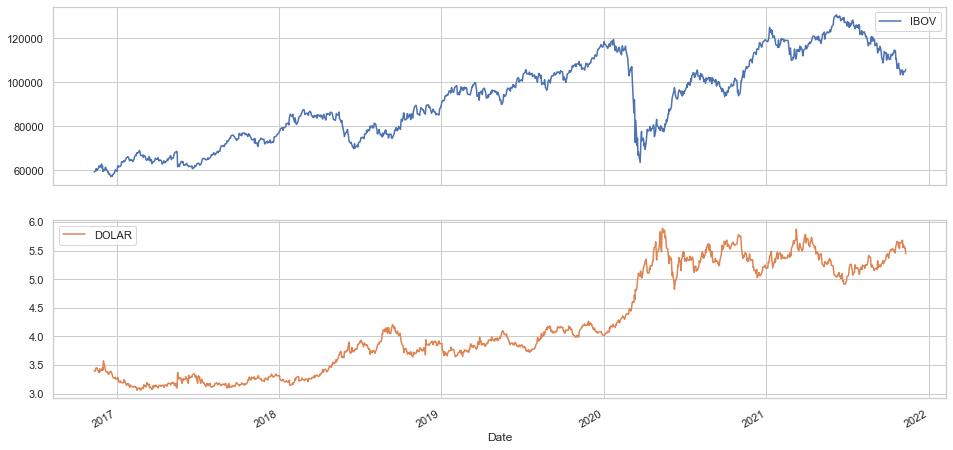

In [8]:
#visualization of data with inputted data
sns.set_theme(style="whitegrid")
ibovDolar.plot(subplots=True, figsize=(16, 8))
plt.show()

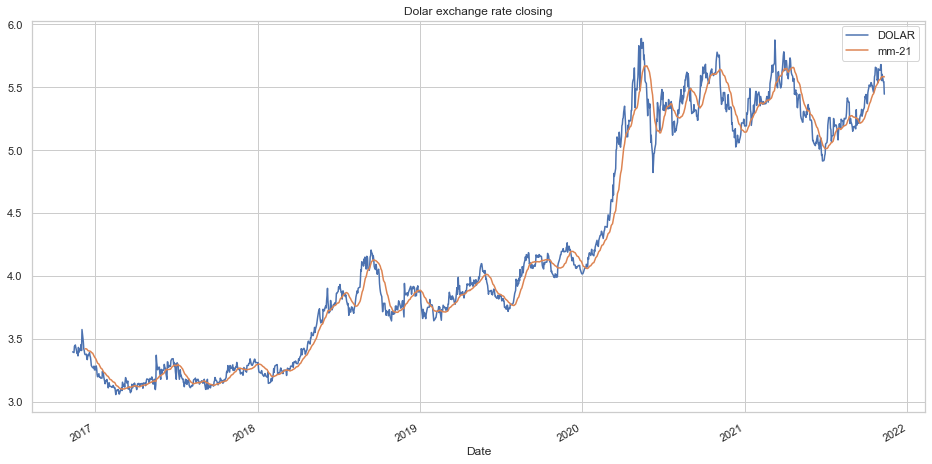

In [9]:
sns.set_theme(style="whitegrid")
ibovDolar['DOLAR'].plot(subplots=False, figsize=(16, 8))
ibovDolar['DOLAR'].rolling(21).mean().plot(label="mm-21")
# Legendas
plt.title('Dolar exchange rate closing')
plt.legend()
plt.show()

### Petrobras(PETR4) stocks and moving average plots

In [10]:
petr4 = web.get_data_yahoo('petr4.sa')
petr4.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2016-11-11,15.46,13.94,15.18,14.01,129811400.0,11.867122
2016-11-14,14.18,13.33,13.80,14.00,86623000.0,11.858649
2016-11-16,14.96,14.18,14.55,14.74,77406600.0,12.485466
2016-11-17,15.32,14.29,15.15,14.29,51535300.0,12.104295
2016-11-18,14.69,14.21,14.37,14.52,55041300.0,12.299116


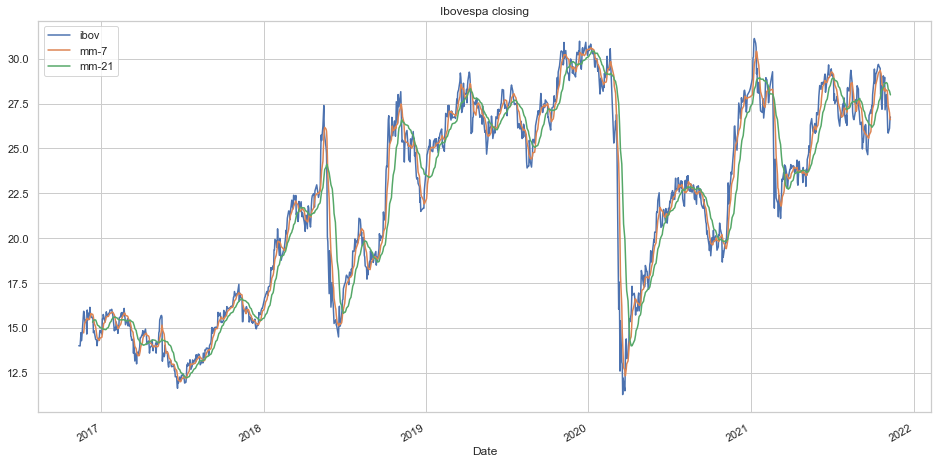

In [11]:
sns.set_theme(style="whitegrid")
# Preço de fechamento
petr4["Close"].plot(figsize=(16, 8), label="ibov")
# Média móvel 7 dias
petr4["Close"].rolling(7).mean().plot(label="mm-7")
# Média móvel 21 dias
petr4["Close"].rolling(21).mean().plot(label="mm-21")
# Legendas
plt.title('Ibovespa closing')
plt.legend()
plt.show()

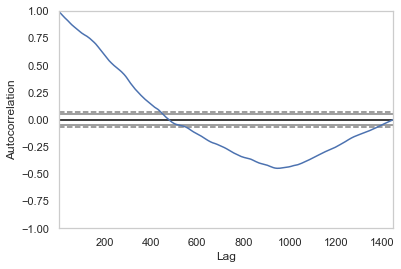

In [12]:
 _ = autocorrelation_plot(ibovDolar['DOLAR'])

### Checking the feasibility for the ARIMA model

In [13]:
ibovDolar.columns

Index(['IBOV', 'DOLAR'], dtype='object', name='Symbols')

In [14]:
ibovDolar2 = ibovDolar.reset_index()

In [15]:
ibovDolar2 = ibovDolar2[(ibovDolar2['Date'] > '2021-1-1')]

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                               SARIMAX Results                                
Dep. Variable:                  DOLAR   No. Observations:                  252
Model:                ARIMA(10, 1, 0)   Log Likelihood                 384.576
Date:                Wed, 10 Nov 2021   AIC                           -747.153
Time:                        11:17:42   BIC                           -708.373
Sample:                             0   HQIC                          -731.547
                                - 252                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0085      0.066     -0.128      0.898      -0.138       0.121
ar.L2         -0.0278      0.061     -0.455      0.649      -0.148       0.092
ar.L3         -0.0990      0.055     -1.797      0.0

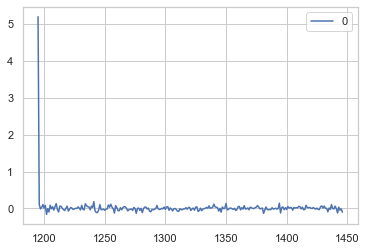

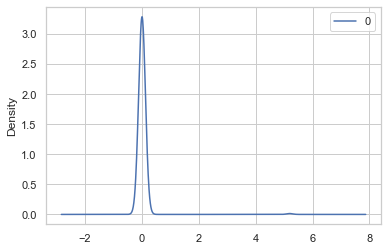

                0
count  252.000000
mean     0.022156
std      0.331116
min     -0.160317
25%     -0.027873
50%      0.000690
75%      0.031544
max      5.191900


In [16]:
model = ARIMA(ibovDolar2['DOLAR'], order=(10,1,0))
model_fit = model.fit()
# summary of fit model
print(model_fit.summary())
# line plot of residuals
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()
# density plot of residuals
residuals.plot(kind='kde')
plt.show()
# summary stats of residuals
print(residuals.describe())

### 1-day ahead forecast with ARIMA algorithm

predicted=5.157028, expected=5.208700
predicted=5.214832, expected=5.174600
predicted=5.166910, expected=5.196800
predicted=5.186089, expected=5.168200
predicted=5.170267, expected=5.245200
predicted=5.255958, expected=5.238600
predicted=5.241579, expected=5.232000
predicted=5.213484, expected=5.231800
predicted=5.223599, expected=5.188300
predicted=5.182530, expected=5.218200
predicted=5.229509, expected=5.252200
predicted=5.249600, expected=5.249850
predicted=5.246725, expected=5.247500
predicted=5.234662, expected=5.259700
predicted=5.259358, expected=5.294300
predicted=5.300412, expected=5.378600
predicted=5.379498, expected=5.414100
predicted=5.405932, expected=5.396550
predicted=5.375498, expected=5.379000
predicted=5.367961, expected=5.379900
predicted=5.382784, expected=5.245800
predicted=5.243016, expected=5.211000
predicted=5.205084, expected=5.251600
predicted=5.261730, expected=5.227200
predicted=5.231341, expected=5.202800
predicted=5.205241, expected=5.182900
predicted=5.

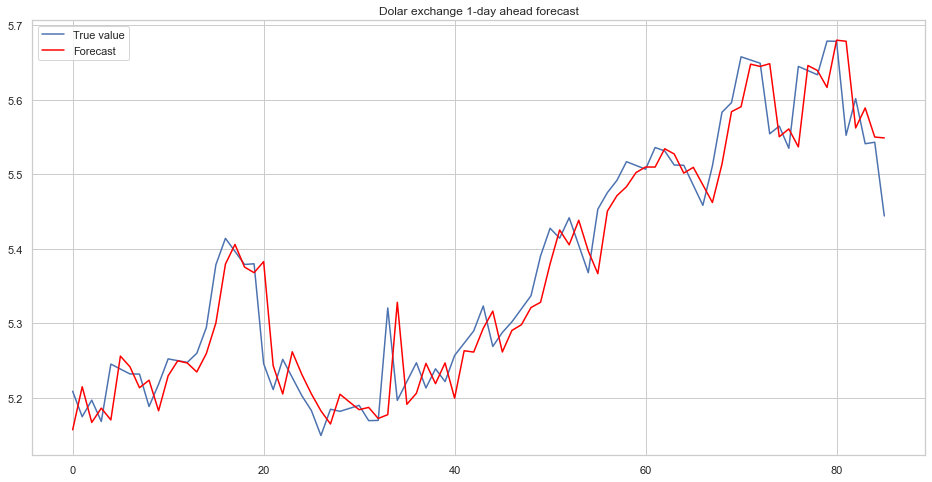

In [20]:
# split into train and test sets
X = ibovDolar2['DOLAR'].values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
# walk-forward validation
for t in range(len(test)):
    model = ARIMA(history, order=(10,1,0))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))
# evaluate forecasts
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)
# plot forecasts against actual outcomes
plt.figure(figsize=(16, 8))
plt.plot(test, label='True value')
plt.plot(predictions, color='red', label = 'Forecast')
plt.legend()
plt.title('Dolar exchange 1-day ahead forecast')
plt.show()

In [18]:
p4 = petr4["Close"].reset_index()
p4 = p4[(p4['Date'] > '2021-1-1')]

predicted=27.164570, expected=27.709999
predicted=27.906904, expected=27.809999
predicted=27.810232, expected=26.910000
predicted=26.973328, expected=26.410000
predicted=26.639429, expected=26.850000
predicted=26.962252, expected=26.280001
predicted=26.126646, expected=28.350000
predicted=28.148528, expected=28.389999
predicted=27.878083, expected=28.190001
predicted=28.056257, expected=28.280001
predicted=28.428012, expected=28.670000
predicted=28.831247, expected=29.100000
predicted=29.177586, expected=29.350000
predicted=29.503524, expected=28.639999
predicted=28.548423, expected=27.030001
predicted=27.194661, expected=26.790001
predicted=27.035791, expected=26.639999
predicted=26.692886, expected=26.600000
predicted=26.489064, expected=27.020000
predicted=26.742553, expected=27.580000
predicted=27.171674, expected=27.730000
predicted=27.561533, expected=27.490000
predicted=27.741751, expected=28.490000
predicted=28.704212, expected=28.299999
predicted=28.342626, expected=27.190001


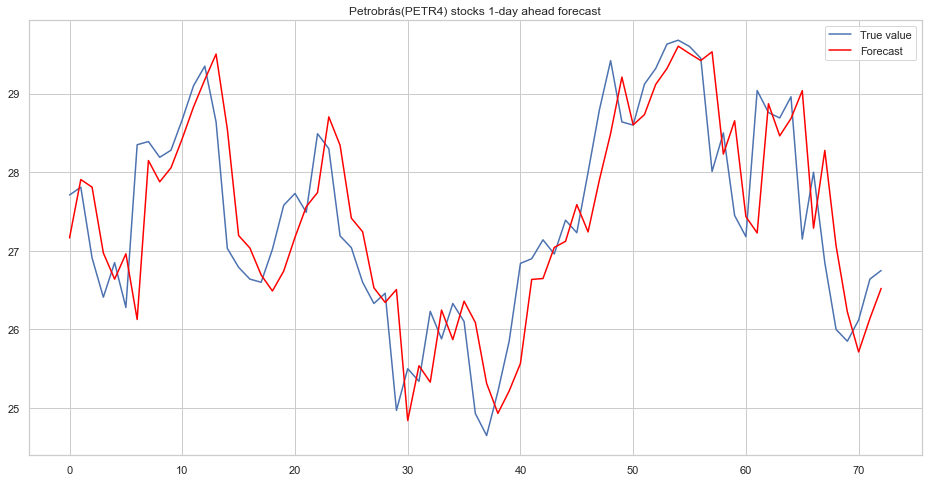

In [19]:
# split into train and test sets
X = p4["Close"].values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
# walk-forward validation
for t in range(len(test)):
    model = ARIMA(history, order=(10,1,0))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))
# evaluate forecasts
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)
# plot forecasts against actual outcomes
plt.figure(figsize=(16, 8))
plt.plot(test, label='True value')
plt.plot(predictions, color='red', label = 'Forecast')
plt.legend()
plt.title('Petrobrás(PETR4) stocks 1-day ahead forecast')
plt.show()